In [1]:
# Scientific libraries
              
import numpy as np              
import scipy as sp              
import pandas as pd              
import json              
import missingno as msno              

# Loading Plotting Modules
              
import matplotlib              
import matplotlib.pyplot as plt              
import seaborn as sns              
%matplotlib inline              
import chart_studio.plotly as py              
import plotly.figure_factory as ff              
import plotly.graph_objects as go              
import plotly.express as px              
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot              
init_notebook_mode(connected=True)              

# Setting Data Frame Options
              
pd.set_option('display.max_rows', 40)              
pd.set_option('display.max_columns', 50)              
pd.set_option('display.width', 100)              
pd.set_option('display.max_colwidth', 100)              

# Setting Plot Configuration
              
sns.set(rc={'figure.figsize':(19,11)}, style = 'white')              

import katana.nbutil as ktn
              
import os

In [2]:
import os
import gc
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import auc, roc_curve

In [3]:
df = pd.read_parquet('../preprocess/output/pre-modeling/merged_data_processed.pqt.gz')                
m, n = df.shape
print('Data Frame: {} x {}'.format(m,n))                
df.head()

Data Frame: 1097231 x 801


,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,TransactionAmt,dist1,dist2,V263,V217,V110,V188,V154,V220,V332,V174,...,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_F,id_35_T,id_35_nan,id_36_F,id_36_T,id_36_nan,id_37_F,id_37_T,id_37_nan,id_38_F,id_38_T,id_38_nan,DeviceType_desktop,DeviceType_mobile,DeviceType_nan,DeviceInfo_MacOS,DeviceInfo_Trident/7.0,DeviceInfo_Windows,DeviceInfo_iOS Device,DeviceInfo_rv:11.0,DeviceInfo_nan,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0.000000,NaN,0.693147,NaN,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,4.226834,2.944439,NaN,NaN,NaN,-0.087282,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0.0
2987001,0.000000,NaN,0.000000,NaN,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,3.367296,NaN,NaN,NaN,NaN,-0.087282,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0.0
2987002,0.000000,NaN,0.000000,NaN,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,4.077537,5.659482,NaN,NaN,NaN,-0.087282,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0.0
2987003,0.693147,NaN,0.000000,NaN,3.218876,0.0,1.609438,NaN,NaN,NaN,1.386294,NaN,NaN,0.0,3.912023,NaN,NaN,NaN,NaN,-0.087282,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0.0
2987004,0.000000,0.0,0.000000,NaN,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,0.0,NaN,3.912023,NaN,NaN,-0.032664,-0.124815,-0.087282,-0.007128,-1.458688,-0.137183,-0.084668,-0.33739,...,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0


In [4]:
idx = pd.read_csv('../preprocess/output/transaction_ids.csv.gz')
del idx['Unnamed: 0']

In [5]:
train = df.loc[idx[idx.train_set_id.notna()]['train_set_id'],:]
dev = df.loc[idx[idx.dev_set_id.notna()]['dev_set_id'],:]
test = df.loc[idx[idx.dev_set_id.notna()]['test_set_id'],:]
del df
gc.collect()

11

In [7]:
os.makedirs('./model_data/reduced_processed', exist_ok=True)
train.to_parquet('./model_data/reduced_processed/train.pqt.gz')
dev.to_parquet('./model_data/reduced_processed/train.pqt.gz')
test.to_parquet('./model_data/reduced_processed/train.pqt.gz')

In [10]:
y_train = train.isFraud
X_train = train.drop('isFraud', axis=1)
y_dev = dev.isFraud
X_dev = dev.drop('isFraud', axis=1)

del train, dev
gc.collect()

490

In [11]:
def auc_plot_score(model_pred_fn, X_train, X_test, y_train, y_test, dim=2): # Function to take a shortcut of printing plots and 
                                                                            # scores of auc for both train and test sets

    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    fig.suptitle('AUC Plots', fontsize=20)
    
    if dim == 1:
        proba_train = model_pred_fn(X_train)
        proba_test  = model_pred_fn(X_test)
    elif dim == 2:
        proba_train = model_pred_fn(X_train)[:,1]
        proba_test  = model_pred_fn(X_test)[:,1]
        
    fpr_train, tpr_train, _ = roc_curve(y_train, proba_train, pos_label=1, drop_intermediate=False)
    auc_train = round(auc(fpr_train, tpr_train),5)
    
    fpr_test,  tpr_test , _ = roc_curve(y_test , proba_test,  pos_label=1, drop_intermediate=False)
    auc_test = round(auc(fpr_test, tpr_test), 5)
    
    axs[0].plot([0, 1], [0, 1], linestyle='--')
    axs[0].plot(fpr_train, tpr_train, marker='.')
    axs[0].set_title('Train')
    axs[0].set_xlabel(auc_train, fontsize=15)
    
    axs[1].plot([0, 1], [0, 1], linestyle='--')
    axs[1].plot(fpr_test, tpr_test, marker='.')
    axs[1].set_title('Test')
    axs[1].set_xlabel(auc_test, fontsize=15)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    
    print(f'Train-set AUC Score = {auc_train}\nTest-set AUC Score = {auc_test}')

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(data=X_train, label=y_train)

params ={
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'verbose': -1
     }

gc.collect()

LightGBM = lgb.train(params=params, train_set = lgb_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



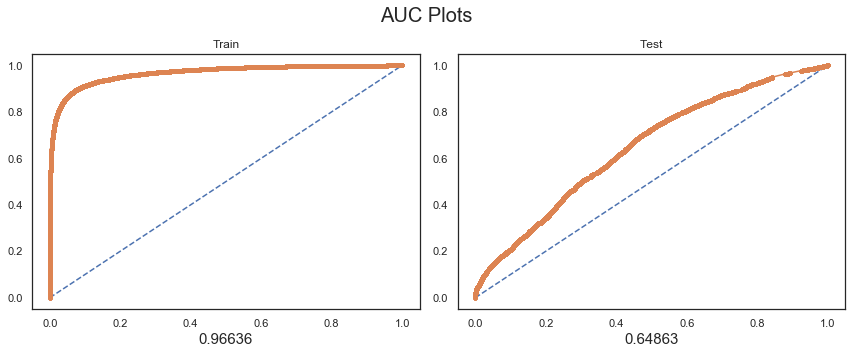

Train-set AUC Score = 0.96636
Test-set AUC Score = 0.64863


In [13]:
auc_plot_score(model_pred_fn=LightGBM.predict, X_train=X_train, X_test=X_dev, 
               y_train=y_train, y_test=y_dev, dim=1)